In [240]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import yaml
import json
import sys

sys.path.append('..')
sys.path.append('../diploma_thesis/')

from environment import Statistics

plt.style.use('seaborn-v0_8-paper')

# Util

In [241]:
def get_parameters(path: str):
    parameters_path = os.path.join(path, 'parameters.yml')

    with open(parameters_path) as f:
        parameters = yaml.safe_load(f)

    return parameters

In [242]:
def plot_value(path: str, info: dict, figsize=(8,8), post_process_fn = lambda a: a):
    if not os.path.exists(path):
        raise ValueError('No loss file exists')

    df = pd.read_csv(path)

    fig, ax = plt.subplots(figsize=figsize)

    if 'work_center_id' in df.columns:
        work_centers = df['work_center_id'].unique()
        machines = df['machine_id'].unique()

        for work_center_id in work_centers:
            for machine_id in machines:
                filtered = df[(df['work_center_id'] == work_center_id) & (df['machine_id'] == machine_id)]
                filtered.set_index(info['index'], inplace=True)

                if len(machines) == 1:
                    label = f'M_idx: {work_center_id}'
                else:
                    label = f'W_idx: {work_center_id}, M_idx: {machine_id}'

                ax.plot(post_process_fn(filtered[info['column']]), label=label)
    else:
        df.set_index(info['index'], inplace=True)

        ax.plot(post_process_fn(df[info['column']]))

    ax.grid(True)
    ax.set_title(info['title'])
    ax.set_xlabel(info['xlabel'])
    ax.set_ylabel(info['ylabel'])

    ax.legend()

    return fig, df

In [243]:
def plot_reward_distribution_per_action(data: pd.DataFrame, figsize=(8, 8)):
    data = data[data['reward'] != 0]

    fig, ax = plt.subplots(figsize=figsize)

    # Create violins for each action
    for i, action in enumerate(data["action"].unique()):
        action_data = data[data["action"] == action]["reward"]
        violin_parts = ax.violinplot(
            action_data,
            positions=[i],
            showmeans=True,
            showextrema=True,
            quantiles=[0.25, 0.5, 0.75],
        )

        violin_parts['bodies'][0].set_linewidth(2)

    # Set labels and title
    ax.set_xlabel("Action")
    ax.set_ylabel("Reward")
    ax.set_title("Violin Plot of Rewards by Action")

    # Add grid and adjust layout
    ax.grid(True)
    plt.tight_layout()

    return fig


In [244]:
def plot_reward_per_run(data, info, format_group):
    metric = info['metric']
    reward = info['reward']
    group = info['group']

    fig, ax = plt.subplots(figsize=(12, 6))

    for run in np.sort(data[group].unique()):
        filtered = data[data[group] == run]

        ax.plot(filtered[metric], filtered[reward], marker=info['marker'], ls='', label=format_group(run))

    ax.grid(True)
    ax.legend()

    ax.set_xlabel(info['xlabel'])
    ax.set_ylabel(info['ylabel'])
    ax.set_title(info['title'])

    plt.tight_layout()

    return fig

def plot_reward_per_model_across_runs(data, info):
    metric = info['metric']
    reward = info['reward']
    group = info['group']
    candidate_column = info['candidate_column']
    candidate = info['candidate']

    fig, ax = plt.subplots(figsize=(12, 6))

    for run in np.sort(data[group].unique()):
        filtered = data[data[group] == run]

        ax.plot(filtered[metric], filtered[reward], marker=info['marker'], ls='', c='gray')

    filtered = data[data[candidate_column] == candidate]

    ax.plot(filtered[metric], filtered[reward], marker=info['marker'], ms=10, ls='', c='r')

    ax.grid(True)

    ax.set_xlabel(info['xlabel'])
    ax.set_ylabel(info['ylabel'])
    ax.set_title(info['title'] + candidate)

    plt.tight_layout()

    return fig

In [245]:
def filter_models(dataset, predicate):
    result = []

    for directory in os.listdir(dataset):
        directory_path = os.path.join(dataset, directory)

        if not os.path.isdir(directory_path):
            continue

        parameters = get_parameters(directory_path)

        if predicate(parameters):
            result += [directory]

    return result

# JSP

In [246]:
dataset = '../diploma_thesis/tmp/jsp_deep_marl/'

## Training

In [269]:
candidate_path = os.path.join(dataset, 'model_137')

In [270]:
agent_path = os.path.join(candidate_path, 'agent')

### Parameters

In [271]:
parameters = get_parameters(candidate_path)

print(json.dumps(parameters, indent=4))

{
    "log_stdout": false,
    "machine_agent": {
        "kind": "mod",
        "parameters": {
            "base_path": "configuration/mods/machine_agent/model.yml",
            "mods": [
                "rl/trainer/dqn.yml",
                "rl/agent/single.yml",
                "memory/prioritized.yml",
                "memory/small.yml",
                "loss/huber.yml",
                "optimizer/sgd.yml",
                "encoding/mr.yml",
                "model/rules/marl.yml",
                "model/model/marl_mr.yml",
                "scheduler/exponential.yml"
            ]
        }
    },
    "name": "model_137",
    "output_dir": "tmp/jsp_deep_marl",
    "run": {
        "kind": "mod",
        "parameters": {
            "base_path": "configuration/mods/run/jsp/run.yml",
            "mods": [
                "util_90.yml"
            ]
        }
    },
    "simulator": {
        "kind": "td"
    },
    "tape": {
        "machine_reward": {
            "kind": "global_deco

### Loss

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,Unnamed: 0,value,lr
optimizer_step,,,
1,0,0.003372,[0.00099996]
2,1,0.005968,[0.0009999200016]
3,2,0.011057,[0.000999880004799936]
4,3,0.014986,[0.0009998400095997438]
5,4,0.014196,[0.0009998000159993597]
...,...,...,...
17922,17921,0.007544,[0.0004882662937809166]
17923,17922,0.009803,[0.00048824676312916534]
17924,17923,0.004512,[0.00048822723325864015]


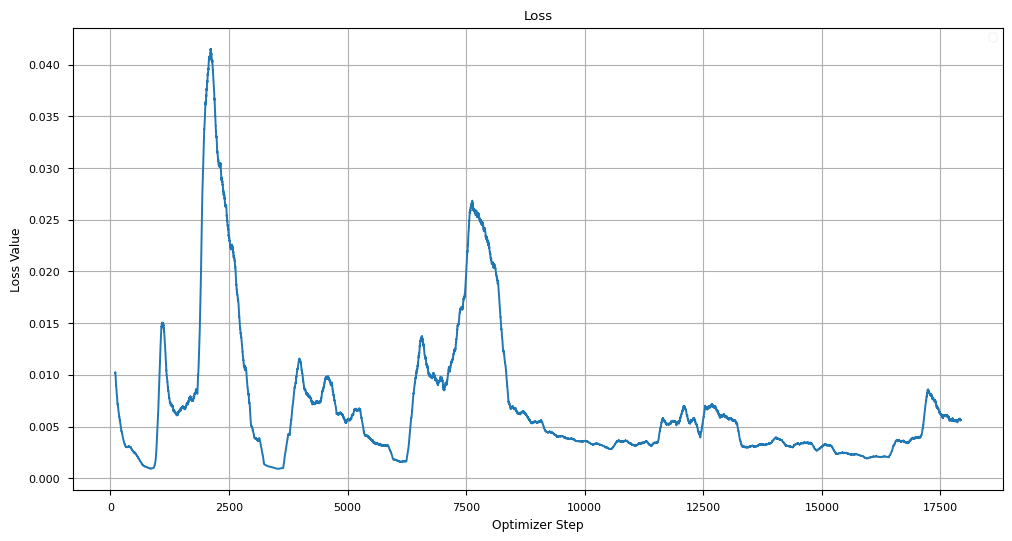

In [272]:
def smooth(x):
    return x.rolling(window=100).mean()

machine_loss = os.path.join(agent_path, 'machine_loss.csv')

fig, loss = plot_value(
    machine_loss,
    info=dict(
        column='value',
        title='Loss',
        xlabel='Optimizer Step',
        ylabel='Loss Value',
        index='optimizer_step'
    ),
    figsize=(12, 6),
    post_process_fn=smooth)

loss

### Reward

,action,work_center_id,reward,moment,machine_id,shop_floor_id
0,3,5,-2.520819e-03,29.579218,0,0
1,2,2,-0.000000e+00,79.579216,0,0
2,1,6,-8.859798e-07,110.579216,0,0
3,0,7,-3.189528e-05,153.016876,0,0
4,1,9,-2.591613e-04,166.579224,0,0
...,...,...,...,...,...,...
25800,0,3,0.000000e+00,99713.468750,0,0
25801,0,8,0.000000e+00,99760.828125,0,0
25802,0,0,0.000000e+00,99813.828125,0,0
25803,1,1,0.000000e+00,99880.828125,0,0


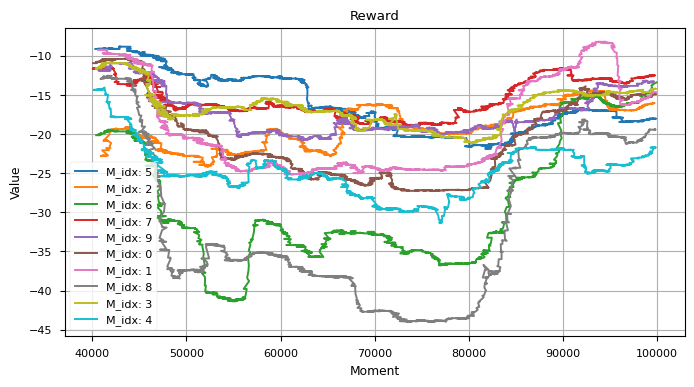

In [273]:
def sum(x):
    return x.rolling(window=1000).sum()

run = '_1'

machine_reward = os.path.join(candidate_path, 'run', run, 'machine_reward.csv')

fig, reward = plot_value(
    machine_reward,
    info=dict(
        column='reward',
        title='Reward',
        xlabel='Moment',
        ylabel='Value',
        index='moment'
    ),
    figsize=(8, 4),
    post_process_fn=sum)

reward

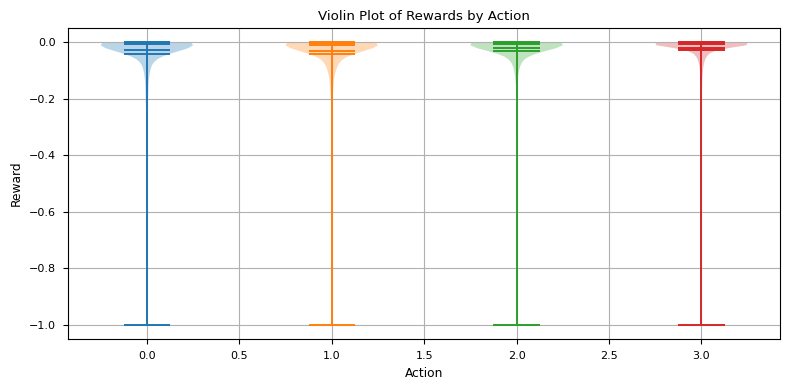

In [274]:
plot_reward_distribution_per_action(reward, figsize=(8,4));

#### Decisions per machine

## Tournament

#### Tournament Result

In [261]:
tournament_path = '../diploma_thesis/tmp/jsp_tournament/'

In [262]:
report_path = os.path.join(tournament_path, 'report.txt')

with open(report_path) as f:
    result = f.readlines()

print(''.join(result))

+----------------------------------------+----------------------+----------------------+---------------------+
|               candidate                |   makespan_reward    |   tardiness_reward   |      total_sum      |
+----------------------------------------+----------------------+----------------------+---------------------+
|          deep_marl_model_123           | 0.08346021827310324  |  0.0798014845083787  | 0.16326170278148194 |
|           deep_marl_model_78           | 0.07507745386101305  |  0.0828714342500375  | 0.15794888811105057 |
|          deep_marl_model_137           |  0.0842181199695915  | 0.07372224364807768  | 0.15794036361766917 |
|           deep_marl_model_89           | 0.07701240479946136  | 0.07919336941060928  | 0.15620577421007065 |
| DPTWINQNPTSchedulingRule_CTRoutingRule | 0.07861128263175488  | 0.07639116033568705  | 0.15500244296744192 |
|   CRSPTSchedulingRule_CTRoutingRule    | 0.07408403162844479  | 0.07905592304711305  | 0.15313995467555785 |
|

In [156]:
result_path = os.path.join(tournament_path, 'result.csv')
results = pd.read_csv(result_path)

#### Tournament Reward Distribution per Simulation

In [157]:
results

,Unnamed: 0,candidate,run,makespan,tardiness,makespan_reward,tardiness_reward
0,0,ATCSchedulingRule_CTRoutingRule,_1,6975.4410,112.191605,0.005581,0.004885
1,1,ATCSchedulingRule_CTRoutingRule,_2,7590.0376,75.801910,0.000000,0.006277
2,2,ATCSchedulingRule_CTRoutingRule,_3,5863.6836,324.494690,0.006738,0.004496
3,3,ATCSchedulingRule_CTRoutingRule,_4,7198.0684,188.008789,0.004765,0.003128
4,4,ATCSchedulingRule_CTRoutingRule,_5,6600.6016,145.458664,0.004204,0.005906
...,...,...,...,...,...,...,...
3325,3325,deep_marl_model_102,_11,6667.0703,238.423630,0.005551,0.003244
3326,3326,deep_marl_model_102,_12,6749.4062,164.393082,0.002946,0.005336
3327,3327,deep_marl_model_102,_13,7552.3047,117.234650,0.003566,0.004722
3328,3328,deep_marl_model_102,_14,6771.5547,171.317032,0.004126,0.005054


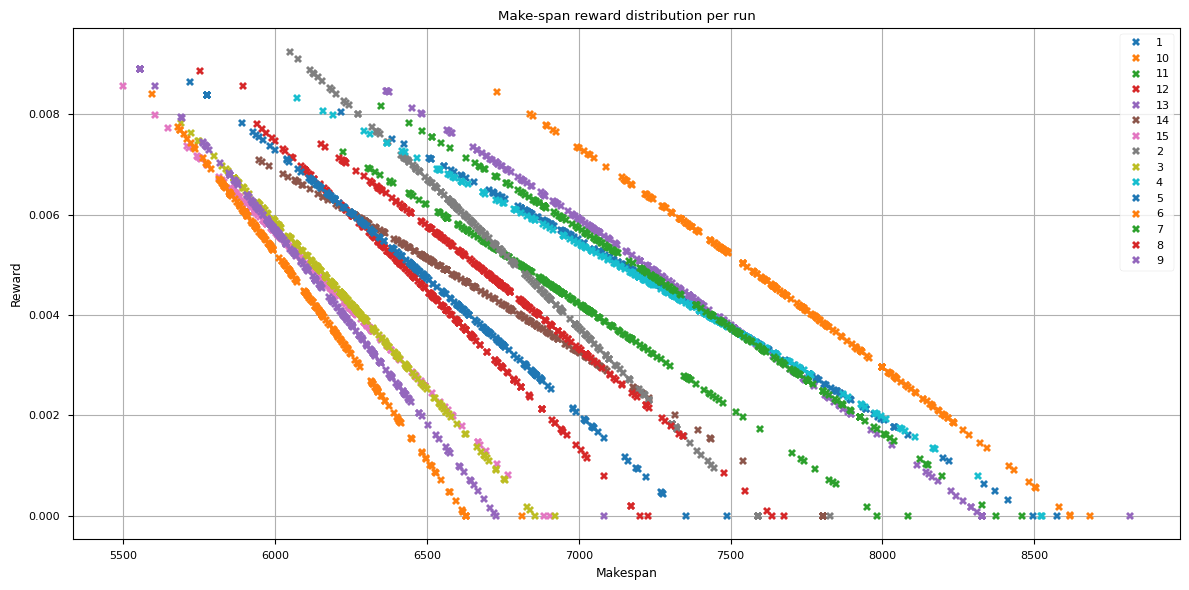

In [158]:
plot_reward_per_run(
    results,
    info=dict(
        title='Make-span reward distribution per run',
        xlabel='Makespan',
        ylabel='Reward',
        marker='X',
        metric='makespan',
        reward='makespan_reward',
        group='run'
    ),
    format_group=lambda x: x.strip('_')
);

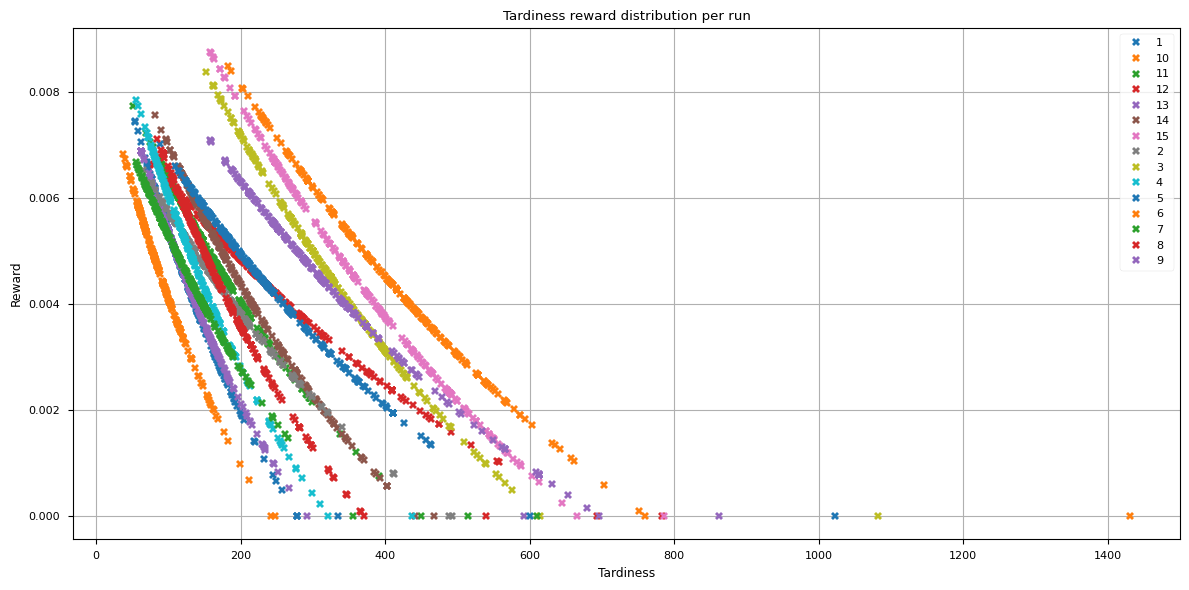

In [159]:
plot_reward_per_run(
    results,
    info=dict(
        title='Tardiness reward distribution per run',
        xlabel='Tardiness',
        ylabel='Reward',
        marker='X',
        metric='tardiness',
        reward='tardiness_reward',
        group='run'
    ),
    format_group=lambda x: x.strip('_')
);

#### Reward Distribution per model

In [160]:
model = 'deep_marl_model_179'

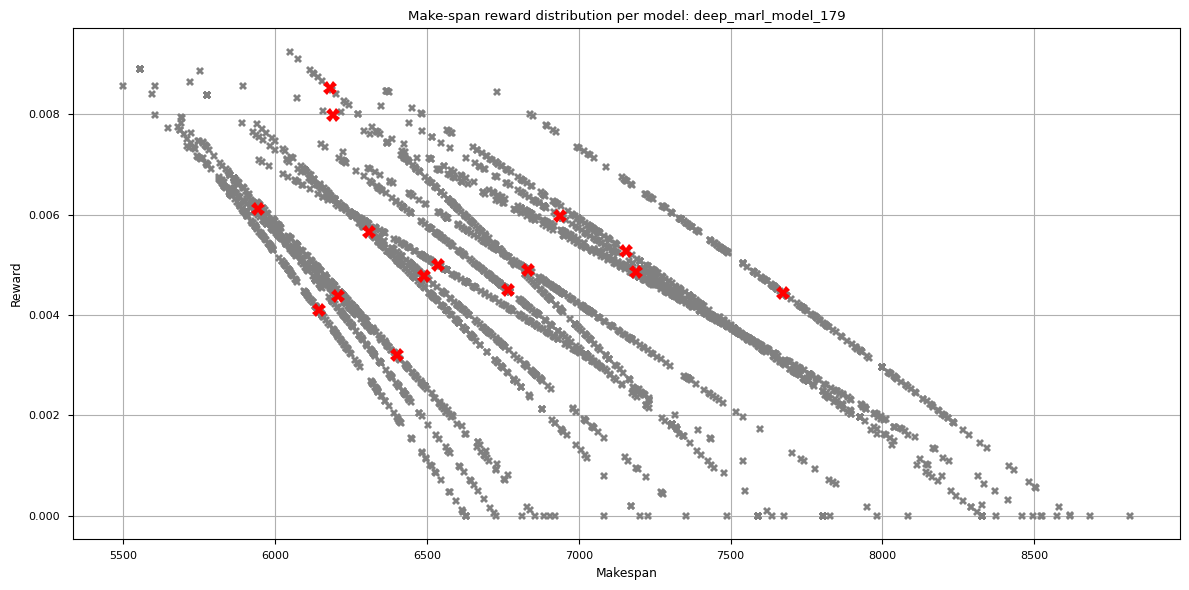

In [161]:
plot_reward_per_model_across_runs(
    results,
    info=dict(
        title='Make-span reward distribution per model: ',
        xlabel='Makespan',
        ylabel='Reward',
        marker='X',
        metric='makespan',
        reward='makespan_reward',
        candidate_column='candidate',
        candidate=model,
        group='run'
    )
);

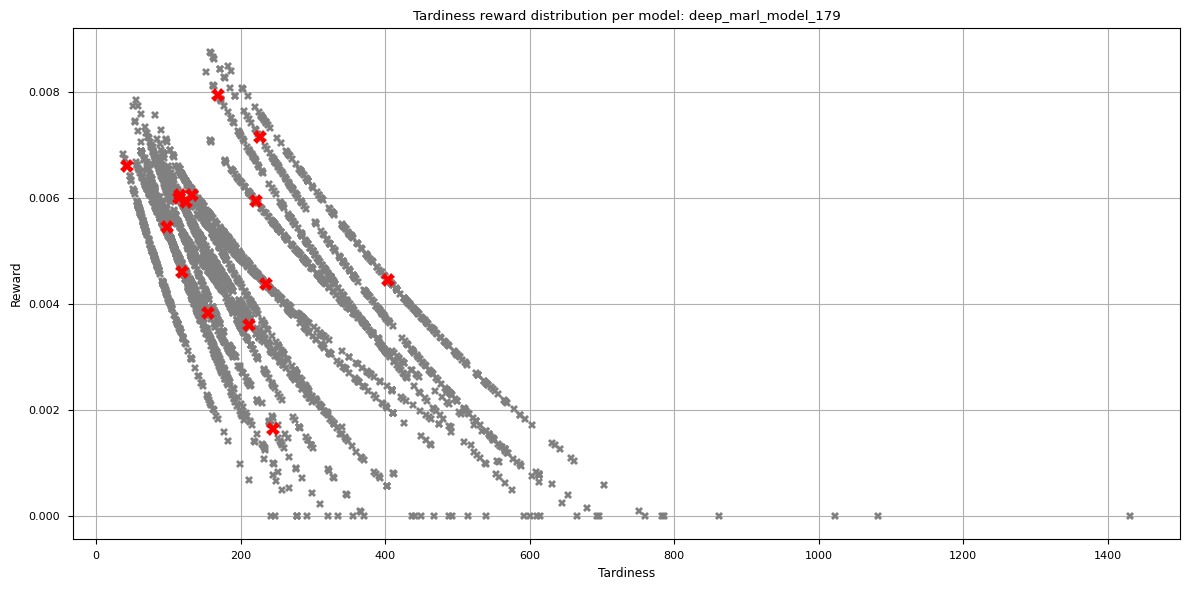

In [162]:
plot_reward_per_model_across_runs(
    results,
    info=dict(
        title='Tardiness reward distribution per model: ',
        xlabel='Tardiness',
        ylabel='Reward',
        marker='X',
        metric='tardiness',
        reward='tardiness_reward',
        candidate_column='candidate',
        candidate=model,
        group='run'
    )
);

#### Analyze results

In [163]:
reward_columns = [column for column in results.columns if 'reward' in column ]

results_per_candidate = results.copy()

results_per_candidate = results_per_candidate[['candidate', *reward_columns]].groupby(['candidate']).sum()
results_per_candidate['reward'] = 0

for column in reward_columns:
    results_per_candidate['reward'] += results_per_candidate[column]

results_per_candidate = results_per_candidate.sort_values(by=['reward'], ascending=False).reset_index()

results_per_candidate

,candidate,makespan_reward,tardiness_reward,reward
0,deep_marl_model_179,0.079675,0.079538,0.159213
1,CRSPTSchedulingRule_CTRoutingRule,0.081866,0.074377,0.156244
2,SPMWKSPTSchedulingRule_CTRoutingRule,0.081866,0.074377,0.156244
3,deep_marl_model_80,0.091500,0.064449,0.155949
4,deep_marl_model_123,0.076300,0.079334,0.155634
...,...,...,...,...
217,deep_marl_model_134,0.053604,0.049991,0.103595
218,LIFOSchedulingRule_CTRoutingRule,0.058968,0.042894,0.101862
219,LROSchedulingRule_CTRoutingRule,0.050136,0.047735,0.097870
220,NPTSchedulingRule_CTRoutingRule,0.053790,0.037780,0.091570


In [164]:
def filter_by_mod(parameters, predicate):
    mods = parameters['machine_agent']['parameters']['mods']

    for mod in mods:
        if predicate(mod):
            return True

    return False

models = filter_models(dataset, lambda parameters: filter_by_mod(parameters, lambda mod: 'priori' in mod))

In [165]:
len(models)

96

In [166]:
candidates = results_per_candidate[results_per_candidate['candidate'].isin(models)]

candidates

,candidate,makespan_reward,tardiness_reward,reward


## Simulation Analysis

#### Utils

In [ ]:
def plot_gantt(production_logs: pd.DataFrame):
    pass

#### Main

In [225]:
run_path = '../diploma_thesis/tmp/test/run/_1/'

In [226]:
statistics = Statistics.load(run_path)

In [228]:
statistics.shop_floor_history.jobs[1].history.started_at

tensor([  0,  59,  89, 102, 147, 166, 216, 246, 414])

In [229]:
print(statistics.report())

+----+------------------------+--------------+------------------+------------+-------------+-------------+--------------+-------------+
|    | weighted_by_priority   |   total_jobs |   completed_jobs |   makespan |   flow_time |   tardiness |   tardy_jobs |   earliness |
|----+------------------------+--------------+------------------+------------+-------------+-------------+--------------+-------------|
|  0 | True                   |          287 |              272 |    9980.04 |     597.084 |     156.959 |     0.683824 |     47.7247 |
|  1 | False                  |          287 |              272 |    9980.04 |  162407     |   42692.8   |   186        |  12981.1    |
+----+------------------------+--------------+------------------+------------+-------------+-------------+--------------+-------------+
+--------------------------+-----------+--------------------+----------------------------------+
|                    index |   runtime |   utilization_rate |   number_of_processed_ope

In [230]:
production_logs = statistics.production_logs
production_logs = production_logs.set_index(['job_id', 'operation_id'])

In [236]:
windows = production_logs[production_logs['event'] == 'started_processing'].copy()
windows = windows[(windows['moment'] < 500) & (windows['moment'] >= 0)]
windows['end_moment'] = production_logs[production_logs['event'] == 'finished_processing']['moment']

windows.drop(['event'], axis=1, inplace=True)
windows = windows.reset_index()

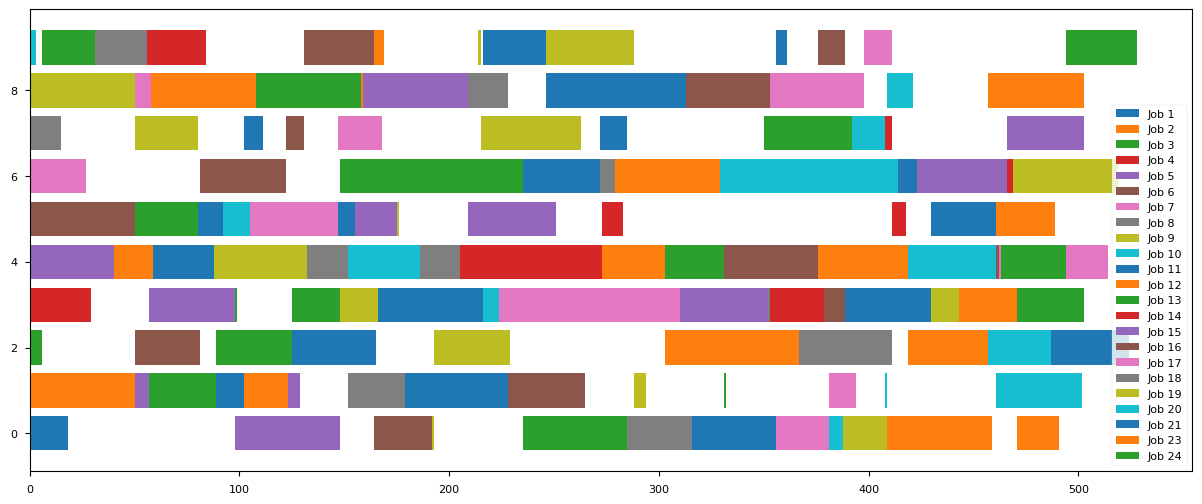

In [239]:
fig, ax = plt.subplots(figsize=(15, 6))

for job_id in windows['job_id'].unique():
    job = windows[windows['job_id'] == job_id]

    rects = ax.barh(
        y=job['work_center_idx'],
        width=job['end_moment'] - job['moment'],
        left=job['moment'],
        label=f'Job {job_id}'
    )

   # ax.bar_label(rects, label_type='center', color='white')

    ax.legend()